In [1]:
import hydra
from omegaconf import OmegaConf
from glob import  glob
from rosa import  predict


BASE_DIR = "/home/ec2-user/outputs/2023-03-09/05-00-32"
config_dir = BASE_DIR + "/.hydra"

with hydra.initialize_config_dir(config_dir=config_dir):
    cfg = hydra.compose(config_name="config", overrides=OmegaConf.load(config_dir + "/overrides.yaml"))

    # chkpts = BASE_DIR + "/checkpoints/epoch=*.ckpt"
    chkpts = BASE_DIR + "/checkpoints/last.ckpt"
    chkpt = glob(chkpts)[0]

    # cfg.data_module.batch_size = 2**14
    adata = predict(cfg, chkpt)

# display(adata)
print(chkpt)

Global seed set to 0
/tmp/ipykernel_90210/1075484123.py:10: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize_config_dir(config_dir=config_dir):
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


RosaLightningModule(
  (model): RosaFormerModel(
    (main): Sequential(
      (dual_embed): ParallelEmbed(
        (models): ModuleList(
          (0): Sequential(
            (input_embed_0): MaskedEmbed(
              (mask): Linear(in_features=1, out_features=256, bias=True)
              (model): Sequential(
                (projection): Linear(in_features=1, out_features=256, bias=True)
                (layer_norm): Identity()
                (dropout): Dropout(p=0, inplace=False)
              )
            )
          )
          (1): Sequential(
            (layer_norm_1): Identity()
            (input_embed_1): InputEmbed(
              (model): Sequential(
                (projection): Linear(in_features=3072, out_features=256, bias=True)
                (layer_norm): Identity()
                (dropout): Dropout(p=0, inplace=False)
              )
            )
          )
        )
      )
      (join_embeds): AddEmbeds()
      (transformer): Performer(
        (net): Sequ

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/opt/conda/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

/home/ec2-user/outputs/2023-03-09/05-00-32/checkpoints/last.ckpt


In [2]:
from rosa.utils import score_predictions, plot_expression_and_correlation, plot_marker_gene_heatmap


adata_test, results = score_predictions(adata)

/opt/conda/envs/pytorch/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())



        mean spearmanr across genes 0.624
        mean spearmanr across cells 0.230
        mean square error 0.694
        ks-statistic on total expression 0.376
        mean percent total expression captured per cell 47.756
        


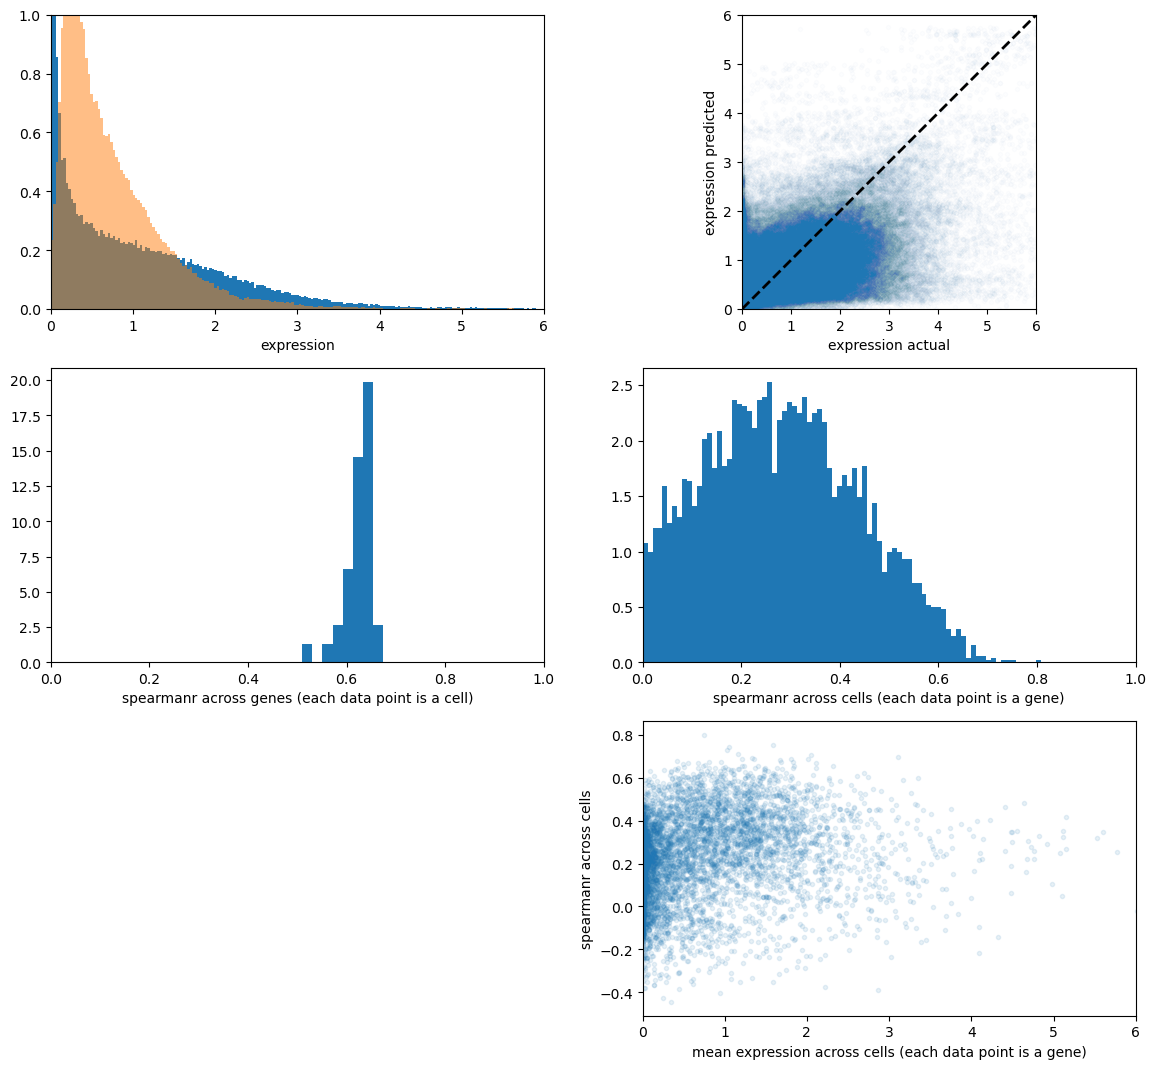

In [3]:
plot_expression_and_correlation(adata_test, results)

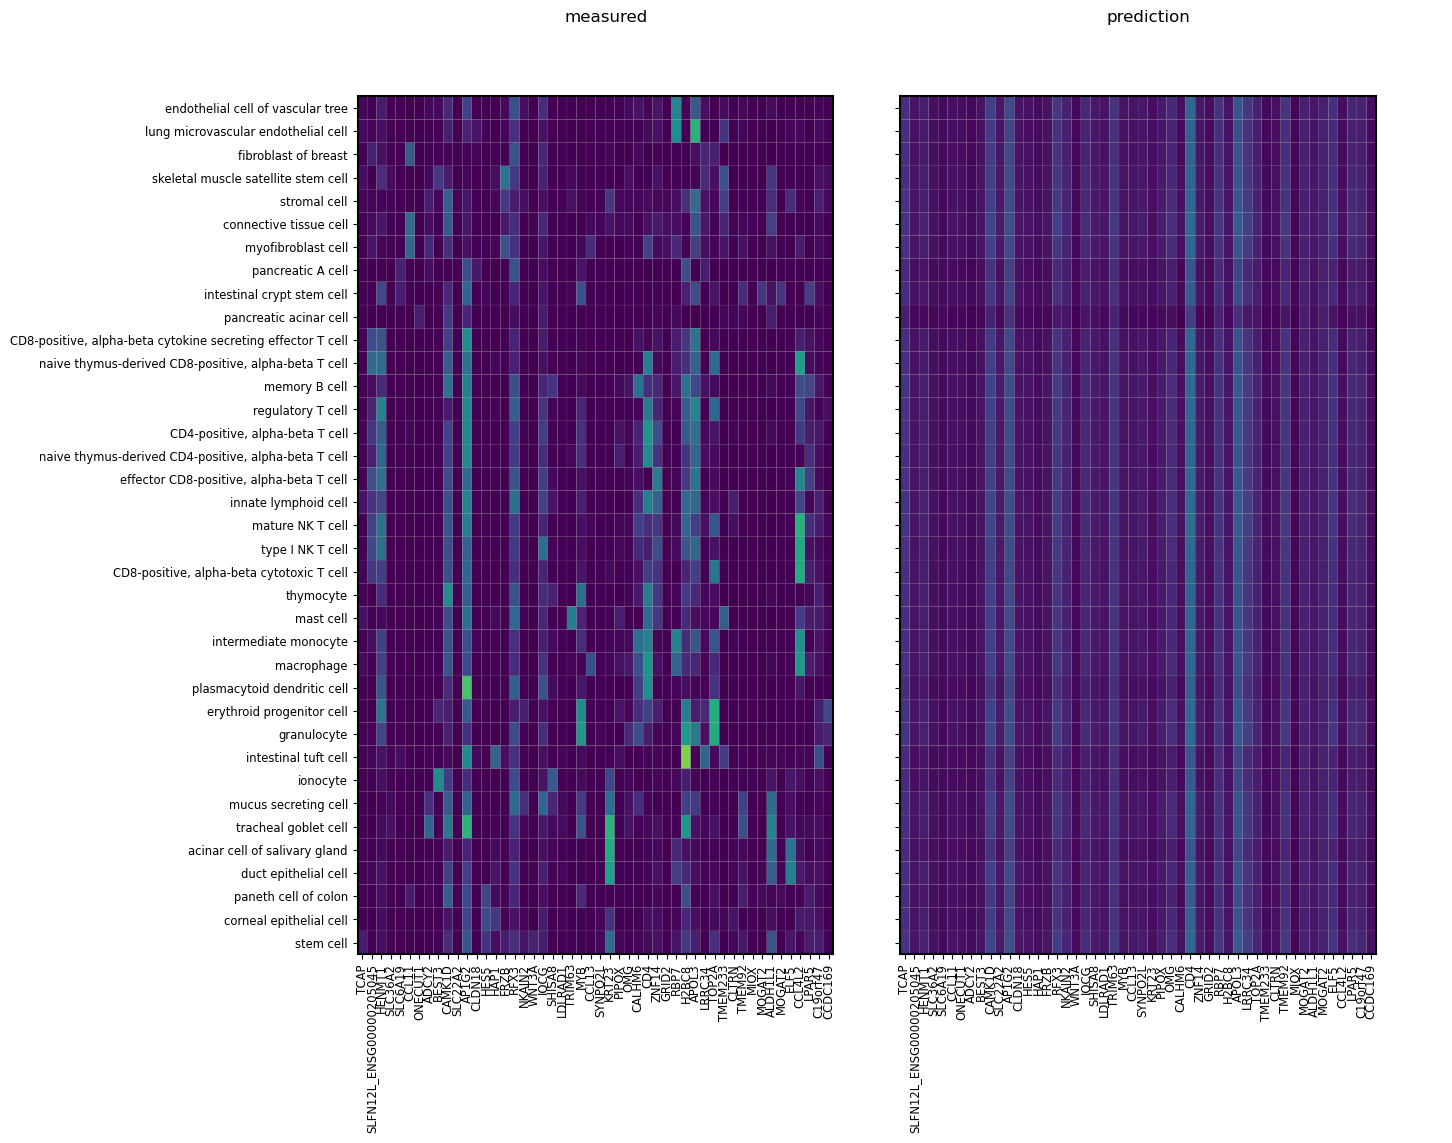

In [4]:
import numpy as np


marker_genes = adata_test.var[adata_test.var['highly_variable']]['feature_name'].values
np.random.seed(42)
marker_genes = np.random.choice(marker_genes, 50)

plot_marker_gene_heatmap(adata_test, marker_genes)

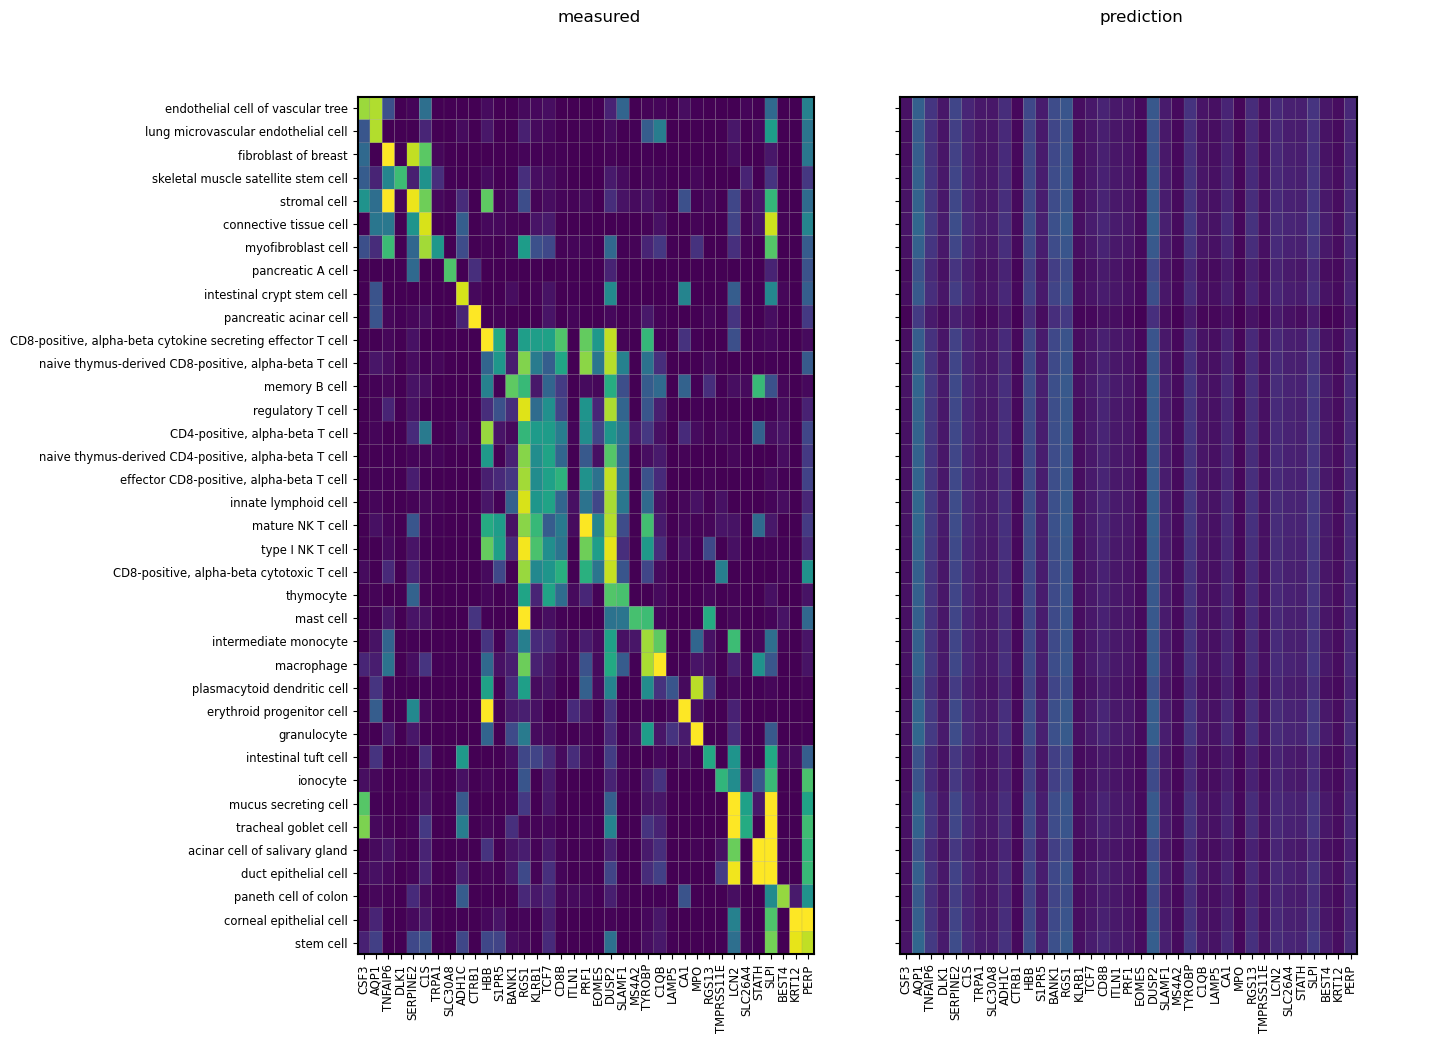

In [5]:
marker_genes_dict = adata_test.obs.set_index('label').to_dict()['marker_feature_name']
plot_marker_gene_heatmap(adata_test, marker_genes_dict)